## Import necessary libraries.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

import matplotlib.pyplot as plt

## Import Data
<p>
Import data from cleaned, encoded, and normalized data from earlier script.
<p>
Data dictionary in repo.

In [2]:
df_encoded_norm = pd.read_csv('Data\ISM647_ML1_data_encoded.csv')

df_encoded_norm.head(10)

,target,AcctAge,DDA,DDABal,Checks,DirDep,NSF,Teller,Sav,SavBal,...,CRScore,Moved,InArea,Dep,DepAmt,Inv,InvBal,Res_R,Res_S,Res_U
0,1,0.000000,1,0.004282,0.000000,0,0,0.00,1,0.014619,...,0.589404,0,1,0.071429,0.002413,0.0,0.000266,1,0,0
1,0,0.006536,1,0.009903,0.020408,1,0,0.00,0,0.000000,...,0.516556,0,1,0.035714,0.000922,0.0,0.000266,1,0,0
2,1,0.062092,0,0.002778,0.000000,0,0,0.00,0,0.000000,...,0.403974,0,1,0.000000,0.000000,0.0,0.000266,0,1,0
3,0,0.003268,1,0.008497,0.020408,0,0,0.04,1,0.000607,...,0.509934,0,1,0.035714,0.002360,0.0,0.000266,0,1,0
4,1,0.104575,1,0.012867,0.040816,0,0,0.20,1,0.003881,...,0.430464,0,1,0.071429,0.002493,0.0,0.000266,0,1,0
5,1,0.196078,1,0.006615,0.265306,1,0,0.36,0,0.000000,...,0.476821,0,1,0.178571,0.014052,0.0,0.000266,0,0,1
6,0,0.138889,1,0.007933,0.244898,1,0,0.00,0,0.000000,...,0.466887,0,1,0.071429,0.004615,0.0,0.000266,0,0,1
7,1,0.147059,1,0.008815,0.040816,1,0,0.00,1,0.001381,...,0.519868,0,1,0.107143,0.001641,0.0,0.000266,0,0,1
8,1,0.009804,1,0.004436,0.081633,0,0,0.08,1,0.012872,...,0.493377,0,1,0.071429,0.002165,0.0,0.000266,0,1,0
9,0,0.044118,1,0.009133,0.020408,1,0,0.04,0,0.000000,...,0.311258,0,1,0.071429,0.002358,0.0,0.000266,0,0,1


## Create train, test, and validate data sets
<p>
80%, 20% split for Train and Test

In [3]:
train, test = np.split(df_encoded_norm.sample(frac=1), [int(0.8*len(df_encoded_norm))])

print(len(train), ':training examples')
print(len(test), ':test examples')

16701 :training examples
4176 :test examples


c:\Users\nlofl\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Check for balance within the target features of the data set by comparing the categorical outcomes.

In [4]:
# check for imbalanced data
df_encoded_norm['target'].value_counts()

target
0    13373
1     7504
Name: count, dtype: int64

Address imbalanced training data using the SMOTE method. (Synthetic Model Oversampling Technique)

In [5]:
# address imbalance in train data using SMOTE method
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
train_smote = train.drop('target', axis=1)
train_target = train['target']
train_smote, train_target = smote.fit_resample(train_smote, train_target)

print(train_smote.shape)
print(train_target.shape)

(21390, 40)
(21390,)


## Train a Random Forest model
<p>
Initialize and train the model.

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# initialize the random forest tree model
rfm = RandomForestClassifier(random_state=42)


Iterate through training to find the best parameters for the decision tree model using random tuning of hyperparameters. (aka parameters outside the model and/or data set)

In [7]:
# estblish the hyperparameters to tune {LARGE MODEL (>10k) BELOW}
param_dist = {
    'n_estimators': randint(100, 1000),  # Number of trees in the forest
    'max_depth': randint(3, 20),  # Maximum depth of each tree
    'min_samples_split': randint(2, 20),  # Minimum number of samples required to split an internal node
    'min_samples_leaf': randint(1, 20),  # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False],  # Whether bootstrap samples are used when building trees
    'criterion': ['gini', 'entropy'],  # The function to measure the quality of a split
    'max_leaf_nodes': [None, 10, 20, 30, 40, 50],  # Grow trees with max_leaf_nodes in best-first fashion if set
    'min_impurity_decrease': uniform(0, 0.1)  # A node will be split if this split induces a decrease of the impurity greater than or equal to this value.
}

# tune the parameters of the model using RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rfm, param_distributions=param_dist, n_iter=100, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)
random_search.fit(train_smote, train_target)

# print the best parameters and best cross-validation accuracy
print(f"Best parameters: {random_search.best_params_}")
print(f"Best cross-validation accuracy: {random_search.best_score_:.2f}")


Best parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 19, 'max_leaf_nodes': 30, 'min_impurity_decrease': 0.001083765148029836, 'min_samples_leaf': 9, 'min_samples_split': 13, 'n_estimators': 364}
Best cross-validation accuracy: 0.73


## Initialize the Training Model Using the Best Parameters
<p>
Initilaize and train the model using the best parameters found above.

In [8]:
# initialize the random forest tree model using the best parameters found in the previous step
rfm_best = RandomForestClassifier(n_estimators = random_search.best_params_['n_estimators'],
                                max_depth = random_search.best_params_['max_depth'],
                                min_samples_split = random_search.best_params_['min_samples_split'],
                                min_samples_leaf = random_search.best_params_['min_samples_leaf'],
                                bootstrap = random_search.best_params_['bootstrap'],
                                criterion = random_search.best_params_['criterion'],
                                max_leaf_nodes = random_search.best_params_['max_leaf_nodes'],
                                min_impurity_decrease = random_search.best_params_['min_impurity_decrease'],
                                random_state=42)

# fit the best parameter model to the training data
rfm_best.fit(train_smote, train_target)

RandomForestClassifier(bootstrap=False, max_depth=19, max_leaf_nodes=30,
                       min_impurity_decrease=0.001083765148029836,
                       min_samples_leaf=9, min_samples_split=13,
                       n_estimators=364, random_state=42)

## Test Model Against Test Data Set
<p>
Use model to predict test target features, then evaluate versus the actual target features in the test data set.

In [9]:
# evaluate the model on the test set
test_target = test.pop('target')

print(test.shape, 'test shape')
print(test_target.shape, 'test target shape')

(4176, 40) test shape
(4176,) test target shape


In [10]:
# predict the target for the test data
test_predictions = rfm_best.predict(test)

# calculate the accuracy of the model
test_accuracy = accuracy_score(test_target, test_predictions)

print('Training accuracy:', test_accuracy)

Training accuracy: 0.703544061302682


## Measurement of Values for Each of the Features Used
<p>
Ranked from most important to least.

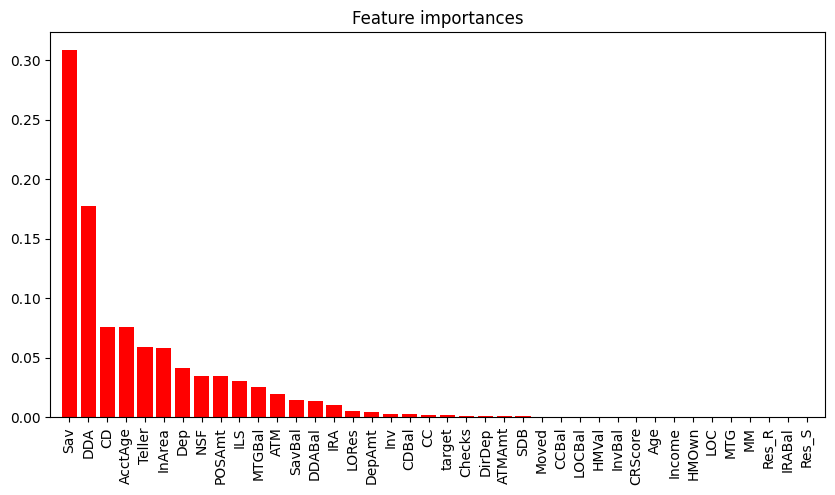

In [11]:
# plot the feature importances
importances = rfm_best.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 5))
plt.title("Feature importances")
plt.bar(range(train_smote.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(train_smote.shape[1]), train.columns[indices], rotation=90)
plt.xlim([-1, train_smote.shape[1]])
plt.show()


## Output Confusion Matrix and Classification Report
<p>
Metrics for performance of model predictions vs test set.

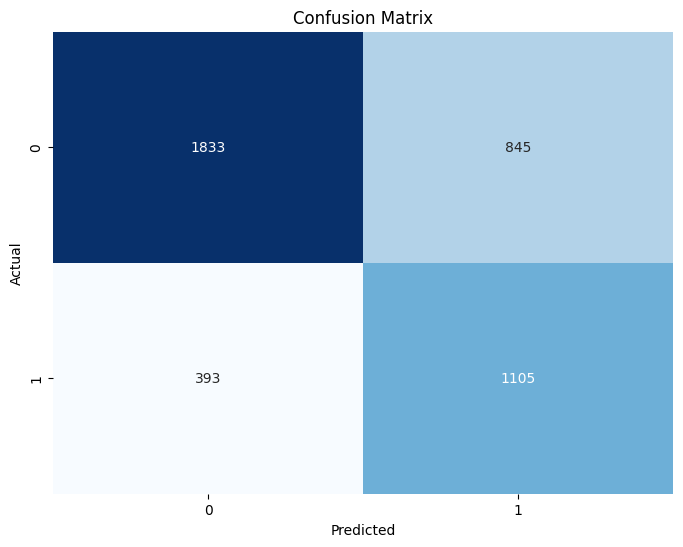

In [12]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# create confusion matrix
conf_matrix = confusion_matrix(test_target, test_predictions)

# plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [13]:
# create a classification report
from sklearn.metrics import classification_report

print(classification_report(test_target, test_predictions))

              precision    recall  f1-score   support

           0       0.82      0.68      0.75      2678
           1       0.57      0.74      0.64      1498

    accuracy                           0.70      4176
   macro avg       0.70      0.71      0.69      4176
weighted avg       0.73      0.70      0.71      4176

